In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
IMG_SIZE = 224
batch_size = 1
builder = tfds.ImageFolder('media/dataset/dogs')
ds_train = builder.as_dataset(split='train', shuffle_files=True)
NUM_CLASSES = builder.info.features["label"].num_classes
print(NUM_CLASSES)

9


In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda example: (tf.image.resize(example['image'], size), example['label']))

In [4]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [5]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)



In [6]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()


In [7]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/2
10/10 [==============================] - 5s 28ms/step - loss: 2.3913 - accuracy: 0.0000e+00
Epoch 2/2
10/10 [==============================] - 0s 14ms/step - loss: 2.4234 - accuracy: 0.0000e+00


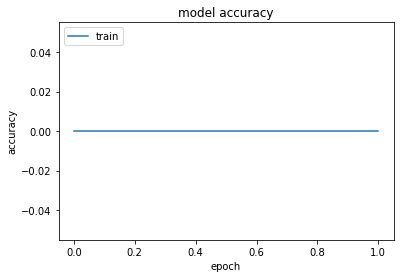

In [8]:
epochs = 2
model = build_model(num_classes=NUM_CLASSES)
# model.load_weights('tf_models/colab/cats_dogs_best_colab1.h5')
print(type(ds_train))
hist = model.fit(ds_train, epochs=epochs)
plot_hist(hist)

In [ ]:
# load saved model
model.save('cats_dogs_retrain.h5')